# **Bio 378 Individual Project**

### By Julia Nelson

In [1]:
# load packages & data

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy


query_results = pd.read_csv('E-GEOD-112057-query-results.csv', skiprows = 3)
analytics = pd.read_csv('E-GEOD-112057-analytics.csv')
raw_counts = pd.read_csv('E-GEOD-112057-raw-counts.csv')
exp_design = pd.read_csv('E-GEOD-112057-experiment-design.csv')

# **Introduction**

In our group project, we explored a dataset that measured differential gene expression in the blood cells of inflammatory bowel disease (IBD) and juvenile idiopathic arthritis (JIA) patients. The dataset looked at both of the main IBDs, Crohn's disease and ulcerative colitis (UC), as well as three types of JIA, oligoarticular juvenile idiopathic arthritis (OJIA), polyarticular juvenile idiopathic arthritis (PJIA), and systemic juvenile idiopathic arthritis (SJIA). It compared gene expression in juvenile patients with each of these conditions to unaffected patients. We performed overenrichment analysis (ORA) on the three most upregulated KEGG pathways found by gene set enrichment analysis. 

However, I was curious what other pathways would be enriched, diminished, or unchanged under each of the five conditions. I particularly wanted to explore how expression of genes in disease pathways changed in patients with that disease. I decided to determine whether expression of genes found in the IBD KEGG pathway was enriched, diminished, or unchanged in Crohn's disease and UC. I also decided to determine whether expression of genes found in the rheumatoid arthritis (RA) KEGG pathway was enriched, diminished, or unchanged in OJIA, PJIA, and SJIA. I expected the pathways to either be significantly enriched or significantly diminished for each condition, since the presence of each gene in the pathway suggests that it has something to do with the disease and would either be upregulated or downregulated as a result of its involvement.

I performed five ORAs in total to determine significant enrichment, significant diminishment, or neither:
- Crohn's disease with IBD pathway
- UC with IBD pathway
- OJIA with RA pathway
- PJIA with RA pathway
- SJIA with RA pathway

# **Normalization**

In [2]:
# allows for normalization of data

def get_tmm(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)

    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]]
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = counts_slim[test_col].sum()
    n_r = counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    w_k = (n_k - counts_slim[test_col].values)/(n_k*counts_slim[test_col].values) + (n_r - counts_slim[ref_col].values)/(n_r*counts_slim[ref_col].values)

    trim_array_m = (m_k <= np.percentile(m_k, 100*(1-(trim_m/2)))) & ((m_k >= np.percentile(m_k, 100*((trim_m/2)))))
    trim_array_a = (a_k <= np.percentile(a_k, 100*(1-(trim_a/2)))) & ((a_k >= np.percentile(a_k, 100*((trim_a/2)))))

    m_k = m_k[trim_array_m & trim_array_a]
    a_k = a_k[trim_array_m & trim_array_a]
    w_k = w_k[trim_array_m & trim_array_a]
    tmm_k = 2**(np.sum(w_k*m_k)/np.sum(w_k))
    return tmm_k

def get_m_a(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)

    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]].copy()
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = 1 #counts_slim[test_col].sum()
    n_r = 1 #counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    return m_k, a_k

def norm_tmm(counts, columns_to_norm, ref_col=None):
    '''
        Normalizes count matrix by TMM.

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        columns_to_norm = columns to be normed (str)

    '''
    if ref_col == None:
        ref_col = columns_to_norm[0]
    counts[counts.columns[~counts.columns.isin(columns_to_norm)]]

    tmm_array = []
    for col in columns_to_norm:
        tmm_array.append(get_tmm(counts = counts, ref_col=ref_col, test_col=col))
    tmm_array = np.array(tmm_array)
    #print(tmm_array)

    norm_counts = counts[columns_to_norm]/(np.sqrt(tmm_array)*counts[columns_to_norm].sum(axis=0))
    norm_counts[counts.columns[~counts.columns.isin(columns_to_norm)]] = counts[counts.columns[~counts.columns.isin(columns_to_norm)]]
    return norm_counts

In [3]:
# normalization

exp_design = exp_design[exp_design['Analysed'] == 'Yes'].reset_index(drop=True)

exp_design['labels'] = ['']*len(exp_design)

# re-labeling
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["Crohn disease"]).all(axis=1), 'labels'] = 'Crohn'
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["ulcerative colitis (disease)"]).all(axis=1), 'labels'] = 'UC'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "systemic-onset juvenile idiopathic arthritis"), 'labels'] = 'SJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "polyarticular juvenile idiopathic arthritis"), 'labels'] = 'PJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "oligoarticular juvenile idiopathic arthritis"), 'labels'] = 'OJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "normal"), 'labels'] = 'NORM'

exp_design = exp_design.sort_values('labels')
cols_to_norm = exp_design['Run'].values
labels = exp_design['labels'].values

# normalizing
counts_norm = raw_counts.copy()
counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

# data normalization
# compare bowel diseases to normal
# compare arthritises to normal
query_results.columns = ['Gene ID', 'Gene Name',
 'Crohn_vs_NORM_fc', 'Crohn_vs_NORM_p',
 'OJIA_vs_NORM_fc', 'OJIA_vs_NORM_p',
 'PJIA_vs_NORM_fc', 'PJIA_vs_NORM_p',
 'SJIA_vs_NORM_fc', 'SJIA_vs_NORM_p',
 'UC_vs_NORM_fc', 'UC_vs_NORM_p',]


In [4]:
# clean up data

# filter for analyzed sample in data
exp_design = exp_design[exp_design['Analysed'] == 'Yes'].reset_index(drop=True)

# make new column to store abbreviation
exp_design['labels'] = ['']*len(exp_design)

# re-label by abbreviation
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["Crohn disease"]).all(axis=1), 'labels'] = 'Crohn'
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["ulcerative colitis (disease)"]).all(axis=1), 'labels'] = 'UC'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "systemic-onset juvenile idiopathic arthritis"), 'labels'] = 'SJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "polyarticular juvenile idiopathic arthritis"), 'labels'] = 'PJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "oligoarticular juvenile idiopathic arthritis"), 'labels'] = 'OJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "normal"), 'labels'] = 'NORM'

# sort exp design by condition
exp_design = exp_design.sort_values('labels')

# filter only Run tag for further normalization
cols_to_norm = exp_design['Run'].values

# preserve label for future use
labels = exp_design['labels'].values

# make copy for query and counts to save raw data
query_result = query_results.copy()
counts_norm = raw_counts.copy()

# re-name query results columns based on relabeled abbreviation
query_result.columns = ['Gene ID', 'Gene Name',
 'Crohn_vs_NORM_fc', 'Crohn_vs_NORM_p',
 'OJIA_vs_PJIA_fc', 'OJIA_vs_PJIA_p',
 'PJIA_vs_SJIA_fc', 'PJIA_vs_SJIA_p',
 'SJIA_vs_NORM_fc', 'SJIA_vs_NORM_p',
 'UC_vs_NORM_fc', 'UC_vs_NORM_p',]

# **Inflammatory Bowel Disease KEGG Pathway**

In [5]:
# genes in inflammatory bowel disease KEGG pathway
ibd_pathway = ['NOD2', 'ATG16L1', 'ABCB1', 'IRF5', 'IL23R', 'IRGM', 'IL10RB', 'IL10RA', 'INAVA', 'CARD8', 'IL37', 'IL10', 'MST1']

The inflammatory bowel disease (IBD) KEGG pathway, H01227, has 13 genes. I selected this pathway because Crohn's disease and ulcerative colitis are the two main IBDs. I would expect the genes involved in the IBD pathway to be either significantly upregulated or significantly downregulated in Crohn's and UC as a result. I want to see if this dataset matches other research on the genes involved in Crohn's disease and UC.

# **Over-Representation Analysis of Crohn's Disease**

I made a volcano plot showing fold-change vs negative log q-value for every gene when Crohn's disease patients are compared to normal patients.

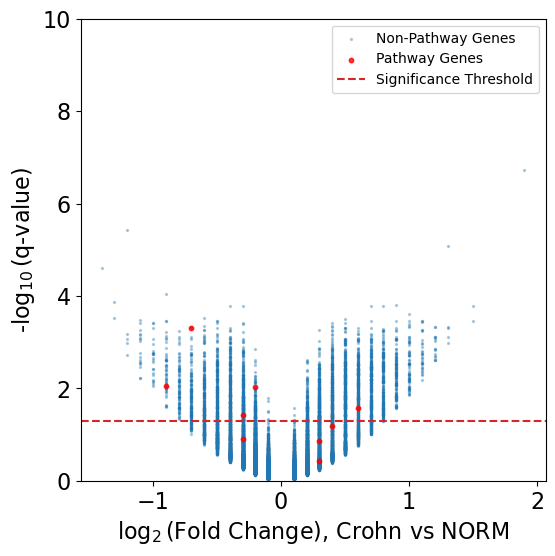

In [6]:
#volcano plot for Crohn's disease vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["Crohn_vs_NORM_fc"],
            -np.log10(query_results["Crohn_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ibd_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "Crohn_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "Crohn_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), Crohn vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot shows that nine genes are both in the IBD pathway and the Crohn's disease condition of the dataset. Four of these genes are significantly downregulated, and one is significantly upregulated.

In [7]:
# select genes upregulated in Crohn's vs normal
fc_truth = query_results["Crohn_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_val_truth = query_results["Crohn_vs_NORM_p"] < 0.05

# collect genes upregulated in Crohn's vs normal
crohn_slice = query_results[fc_truth & q_val_truth]
crohn_slice.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_fc,Crohn_vs_NORM_p
1,ENSG00000000419,DPM1,0.3,0.018463
24,ENSG00000002834,LASP1,0.4,0.020804
25,ENSG00000002919,SNX11,0.4,0.010853
34,ENSG00000003402,CFLAR,0.5,0.016424
54,ENSG00000004809,SLC22A16,0.6,0.048388
...,...,...,...,...
20362,ENSG00000284882,ENSG00000284882,0.6,0.038017
20374,ENSG00000285006,ENSG00000285006,0.9,0.014551
20399,ENSG00000285444,ENSG00000285444,1.2,0.001429
20460,ENSG00000285909,ENSG00000285909,0.9,0.024139


2274 of the 58735 genes in the dataset are significantly upregulated in Crohn's disease. This represents 3.87% of the genes in the dataset.

In [8]:
# determine which genes in both crohn_slice & ibd_pathway
crohn_cond = crohn_slice['Gene Name'].isin(ibd_pathway)
crohn_filter = crohn_slice[crohn_cond]
crohn_filter.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_fc,Crohn_vs_NORM_p
9723,ENSG00000167207,NOD2,0.6,0.02638


Only one gene, NOD2, is both in the IBD pathway and is significantly upregulated in Crohn's disease. This matches the volcano plot.

In [9]:
# number of genes in crohn_cond
k = np.sum(crohn_cond)
# number of genes in crohn_slice
N = len(crohn_slice)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in analytics
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 2274
n = 12
M = 20473
Enrichment ratio: 0.750256523013779
p-value: 0.7566577872292712


The p-value of .76 (> .05) shows that the IBD pathway is not significantly enriched in those with Crohn's disease. This is somewhat unexpected, as Crohn's disease is an IBD and we would expect these genes to be upregulated. It is possible that the genes in the IBD pathway are actually *downregulated* in Crohn's disease instead of upregulated, and we will test that next.

In [10]:
# select genes downregulated in Crohn's vs normal
fc_truth2 = query_results["Crohn_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_val_truth2 = query_results["Crohn_vs_NORM_p"] < 0.05

# collect genes downregulated in Crohn's vs normal
crohn_slice2 = query_results[fc_truth2 & q_val_truth2]
crohn_slice2.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_fc,Crohn_vs_NORM_p
11,ENSG00000001497,LAS1L,-0.2,0.038862
15,ENSG00000001631,KRIT1,-0.2,0.049484
16,ENSG00000002016,RAD52,-0.3,0.020685
40,ENSG00000004139,SARM1,-0.5,0.004055
61,ENSG00000004975,DVL2,-0.3,0.007960
...,...,...,...,...
20396,ENSG00000285417,ENSG00000285417,-0.5,0.038799
20412,ENSG00000285578,ENSG00000285578,-1.0,0.003748
20433,ENSG00000285752,CDC42-AS1,-0.5,0.020228
20458,ENSG00000285897,ENSG00000285897,-0.5,0.045093


1623 of the 58735 genes in the dataset are significantly downregulated in Crohn's disease. This represents 2.76% of the genes in the dataset.

In [11]:
# determine which genes in both crohn_slice2 & ibd_pathway
crohn_cond2 = crohn_slice2['Gene Name'].isin(ibd_pathway)
crohn_filter2 = crohn_slice2[crohn_cond2]
crohn_filter2.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_fc,Crohn_vs_NORM_p
1428,ENSG00000085563,ABCB1,-0.7,0.000487
1442,ENSG00000085978,ATG16L1,-0.2,0.009499
3191,ENSG00000110324,IL10RA,-0.3,0.038246
8778,ENSG00000162594,IL23R,-0.9,0.008877


Four genes--ABCB1, ATG16L1, IL10RA, and IL23R--are in both the IBD pathway and are significantly downregulated in Crohn's disease. This matches the volcano plot.

In [12]:
# number of genes in crohn_cond2
k = np.sum(crohn_cond2)
# number of genes in crohn_slice2
N = len(crohn_slice2)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in analytics
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 4
N = 1623
n = 12
M = 20473
Enrichment ratio: 4.2047648387759295
p-value: 0.011612112739460875


The p-value of .01 (< .05) shows that the IBD pathway is significantly diminished in those with Crohn's disease. The functions of these genes are likely impaired by Crohn's disease and other IBDs. The enrichment ratio of 4.20 shows that the genes are about 4.20 times less prevalent among the input dataset than the reference dataset. Now we will determine if the IBD pathway is upregulated or downregulated in UC.

# **Over-Representation Analysis of Ulcerative Colitis**

I made a volcano plot showing fold-change vs negative log q-value for every gene when UC patients are compared to normal patients.

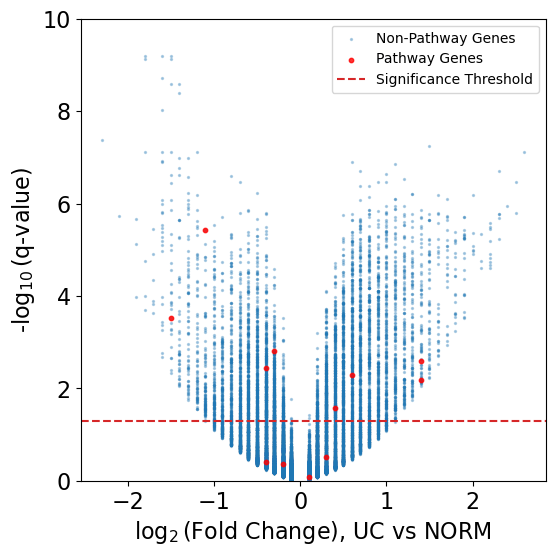

In [13]:
#volcano plot for UC vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["UC_vs_NORM_fc"],
            -np.log10(query_results["UC_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ibd_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "UC_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "UC_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), UC vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot shows that twelve genes are both in the IBD pathway and the UC condition of the dataset. Four of these genes are significantly downregulated, and four are significantly upregulated.

In [14]:
# select genes upregulated in UC vs normal
fc_truth3 = query_results["UC_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_val_truth3 = query_results["UC_vs_NORM_p"] < 0.05

# collect genes upregulated in UC vs normal
uc_slice = query_results[fc_truth3 & q_val_truth3]
uc_slice.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,UC_vs_NORM_fc,UC_vs_NORM_p
1,ENSG00000000419,DPM1,0.4,0.003457
4,ENSG00000000938,FGR,0.5,0.048836
21,ENSG00000002726,AOC1,1.1,0.042997
24,ENSG00000002834,LASP1,0.5,0.001242
25,ENSG00000002919,SNX11,0.6,0.000202
...,...,...,...,...
20408,ENSG00000285534,ENSG00000285534,1.2,0.017380
20459,ENSG00000285906,ENSG00000285906,0.9,0.011584
20460,ENSG00000285909,ENSG00000285909,1.1,0.027332
20464,ENSG00000285938,ENSG00000285938,1.2,0.002374


3345 of the 58735 genes in the dataset are significantly upregulated in UC. This represents 5.70% of the genes in the dataset.

In [15]:
# determine which genes in both uc_slice & ibd_pathway
uc_cond = uc_slice['Gene Name'].isin(ibd_pathway)
uc_filter = uc_slice[uc_cond]
uc_filter.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,UC_vs_NORM_fc,UC_vs_NORM_p
2657,ENSG00000105483,CARD8,0.4,0.026615
6064,ENSG00000136634,IL10,1.4,0.002596
8930,ENSG00000163362,INAVA,1.4,0.006761
16650,ENSG00000243646,IL10RB,0.6,0.005262


Four genes--CARD8, IL10, INAVA, and IL10RB--are in both the IBD pathway and are significantly upregulated in UC. This matches the volcano plot.

In [16]:
# number of genes in uc_cond
k = np.sum(uc_cond)
# number of genes in uc_slice
N = len(uc_slice)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in query)resukts
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 4
N = 3345
n = 12
M = 20473
Enrichment ratio: 2.040159441953164
p-value: 0.11822003220084853


The p-value of .12 (> .05) shows that the inflammatory bowel disease pathway is not significantly enriched in those with UC. This is unexpected, as UC is an inflammatory bowel disease and we would expect these genes to be upregulated. It is possible that the genes in the IBD pathway are actually *downregulated* in UC instead of upregulated, as they are for Crohn's disease. We will test that next.

In [17]:
# select genes downregulated in UC vs normal
fc_uc2 = query_results["UC_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_uc2 = query_results["UC_vs_NORM_p"] < 0.05

# collect genes downregulated in UC vs normal
uc_slice2 = query_results[fc_uc2 & q_uc2]
uc_slice2.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,UC_vs_NORM_fc,UC_vs_NORM_p
5,ENSG00000000971,CFH,-0.8,0.016450
11,ENSG00000001497,LAS1L,-0.4,0.001773
23,ENSG00000002822,MAD1L1,-0.6,0.001091
40,ENSG00000004139,SARM1,-0.7,0.000903
46,ENSG00000004487,KDM1A,-0.2,0.010849
...,...,...,...,...
20412,ENSG00000285578,ENSG00000285578,-1.0,0.032063
20428,ENSG00000285728,ENSG00000285728,-0.8,0.007848
20433,ENSG00000285752,CDC42-AS1,-0.7,0.011149
20435,ENSG00000285761,ENSG00000285761,-0.8,0.022080


2689 of the 58735 genes in the dataset are significantly upregulated in UC. This represents 4.58% of the genes in the dataset.

In [18]:
# determine which genes in both uc_slice2 & ibd_pathway
uc_cond2 = uc_slice2['Gene Name'].isin(ibd_pathway)
uc_filter2 = uc_slice2[uc_cond2]
uc_filter2.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,UC_vs_NORM_fc,UC_vs_NORM_p
1428,ENSG00000085563,ABCB1,-1.1,0.000004
1442,ENSG00000085978,ATG16L1,-0.3,0.001568
3191,ENSG00000110324,IL10RA,-0.4,0.003647
8778,ENSG00000162594,IL23R,-1.5,0.000300


Four genes--ABCB1, ATG16L1, IL10RA, and IL23R--are in both the IBD pathway and are significantly downregulated in UC. This matches the volcano plot.

In [19]:
# number of genes in uc_cond2
k = np.sum(uc_cond2)
# number of genes in uc_slice2
N = len(uc_slice2)
# number of genes in both query_results & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in query_results
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 4
N = 2689
n = 12
M = 20473
Enrichment ratio: 2.5378703359365313
p-value: 0.06158279555612233


The p-value of .06 (> .05) shows that the inflammatory bowel disease pathway isn't significantly diminished in those with ulcerative colitis. This is unexpected, as UC is an IBD so we would expect these genes to be either upregulated or downregulated and neither is true. These results match the volcano plot, which shows an equal number of genes upregualted and downregulated. It is likely that different genes have different roles in UC, with some being signficantly upregualted and others being significantly downregulated. 

# **KEGG Pathway for Juvenile Idiopathic Arthritis**

In [20]:
ra_pathway = ['HLA-DRB1', 'PTPN22', 'CIITA', 'CD244', 'SLC22A4', 'IRF5', 'NFKBIL1', 'IL10', 'IL6', 'MIF']

The rheumatoid arthritis (RA) KEGG pathway, H00630, has 10 genes. I selected this pathway because juvenile idiopathic arthritis, which oligoarticular JIA, polyarticular JIA, and systemic JIA are subtypes of, is itself a subtype of RA. I would expect the genes involved in the RA pathway to be either significantly upregulated or significantly downregulated in OJIA, PJIA, and SJIA as a result. I want to see if this dataset matches other research on the genes involved in OJIA, PJIA, and SJIA.

# **Over-Representation Analysis of Oligoarticular Juvenile Idiopathic Arthritis**

I made a volcano plot showing fold-change vs negative log q-value for every gene when OJIA patients are compared to normal patients.

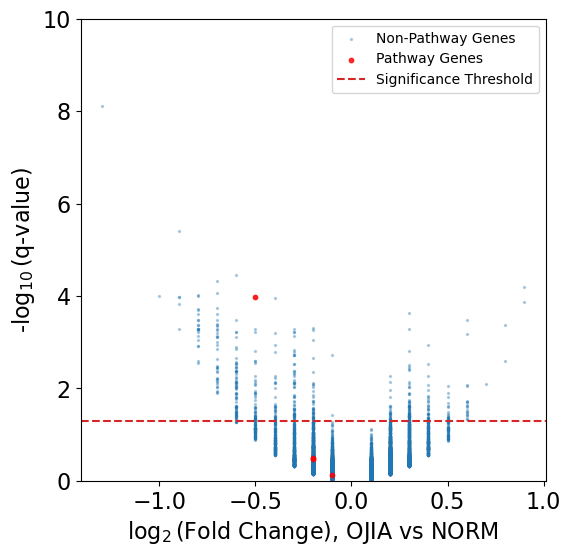

In [21]:
#volcano plot for OJIA vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["OJIA_vs_NORM_fc"],
            -np.log10(query_results["OJIA_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ra_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "OJIA_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "OJIA_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), OJIA vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot shows that three genes are both in the RA pathway and the OJIA condition of the dataset. One of these genes is significantly downregulated.

In [22]:
# select genes upregulated in OJIA vs normal
fc_ojia = query_results["OJIA_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_ojia = query_results["OJIA_vs_NORM_p"] < 0.05

# collect genes upregulated in OJIA vs normal
ojia_slice = query_results[fc_ojia & q_ojia]
ojia_slice.iloc[:, [0,1,4,5]]

,Gene ID,Gene Name,OJIA_vs_NORM_fc,OJIA_vs_NORM_p
114,ENSG00000006459,KDM7A,0.3,0.012969
235,ENSG00000011114,BTBD7,0.2,0.005352
241,ENSG00000011258,MBTD1,0.2,0.024524
529,ENSG00000047634,SCML1,0.5,0.008792
723,ENSG00000062725,APPBP2,0.3,0.008216
...,...,...,...,...
19944,ENSG00000279192,PWAR5,0.6,0.035101
20018,ENSG00000279561,ENSG00000279561,0.6,0.029305
20184,ENSG00000280734,LINC01232,0.4,0.035308
20200,ENSG00000281181,ENSG00000281181,0.7,0.008155


165 of the 58735 genes in the dataset are significantly upregulated in OJIA. This represents .28% of the genes in the dataset.

In [23]:
# determine which genes in both ojia_slice & ra_pathway
ojia_cond = ojia_slice['Gene Name'].isin(ra_pathway)
ojia_filter = ojia_slice[ojia_cond]
ojia_filter.iloc[:, [0,1,4,5]]

,Gene ID,Gene Name,OJIA_vs_NORM_fc,OJIA_vs_NORM_p


No genes are in both the RA pathway and are significantly upregulated in OJIA. This matches the volcano plot and means that the RA pathway itself isn't significantly upregulated in OJIA. Now I will look at genes that are significantly downregulated in OJIA.

In [24]:
# select genes downregulated in OJIA vs normal
fc_ojia2 = query_results["OJIA_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_ojia2 = query_results["OJIA_vs_NORM_p"] < 0.05

# collect genes downregulated in OJIA vs normal
ojia_slice2 = query_results[fc_ojia2 & q_ojia2]
ojia_slice2.iloc[:, [0,1,4,5]]

,Gene ID,Gene Name,OJIA_vs_NORM_fc,OJIA_vs_NORM_p
19,ENSG00000002586,CD99,-0.3,0.013957
81,ENSG00000005379,TSPOAP1,-0.7,0.000970
94,ENSG00000005844,ITGAL,-0.3,0.003022
117,ENSG00000006555,TTC22,-0.4,0.033178
144,ENSG00000007264,MATK,-0.6,0.003035
...,...,...,...,...
19527,ENSG00000274588,DGKK,-0.7,0.009356
19550,ENSG00000274897,ENSG00000274897,-0.6,0.033478
19588,ENSG00000275302,CCL4,-0.6,0.007802
19659,ENSG00000276070,CCL4L2,-0.8,0.002529


311 of the 58735 genes in the dataset are significantly upregulated in OJIA. This represents .53% of the genes in the dataset.

In [25]:
# determine which genes in both ojia_slice & ra_pathway
ojia_cond2 = ojia_slice2['Gene Name'].isin(ra_pathway)
ojia_filter2 = ojia_slice2[ojia_cond2]
ojia_filter2.iloc[:, [0,1,4,5]]

,Gene ID,Gene Name,OJIA_vs_NORM_fc,OJIA_vs_NORM_p
4414,ENSG00000122223,CD244,-0.5,0.000108


One gene, CD244, is in both the RA pathway and is significantly downregulated in OJIA. This matches the volcano plot

In [26]:
# number of genes in ojia_cond2
k = np.sum(ojia_cond2)
# number of genes in ojia_slice2
N = len(ojia_slice2)
# number of genes in both query_results & ra_pathway
n = np.sum(query_results['Gene Name'].isin(ra_pathway))
# number of genes in query_results
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 311
n = 10
M = 20473
Enrichment ratio: 6.582958199356914
p-value: 0.1419620223650477


The p-value of .14 (> .05) shows that the RA pathway isn't significantly diminished in those with OJIA. This is unexpected, as OJIA is an RA so we would expect these genes to be either upregulated or downregulated and neither is true. These results correspond to the volcano plot, which shows three genes downregulated but only one of those significantly downregulated. It's likely that the dataset doesn't contain enough genes from the RA pathway to show significant enrichment or diminishment in patients with OJIA.

# **Over-Representation Analysis of Polyarticular Juvenile Idiopathic Arthritis**

I made a volcano plot showing fold-change vs negative log q-value for every gene when PJIA patients are compared to normal patients.

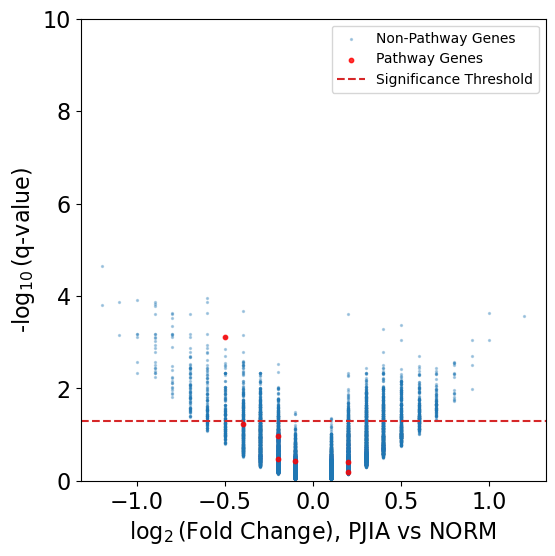

In [27]:
#volcano plot for PJIA vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["PJIA_vs_NORM_fc"],
            -np.log10(query_results["PJIA_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ra_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "PJIA_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "PJIA_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), PJIA vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot shows that seven genes are both in the RA pathway and the PJIA of the dataset. One of these genes is significantly downregulated.

In [28]:
# select genes upregulated in PJIA vs normal
fc_pjia = query_results["PJIA_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_pjia = query_results["PJIA_vs_NORM_p"] < 0.05

# collect genes upregulated in PJIA vs normal
pjia_slice = query_results[fc_pjia & q_pjia]
pjia_slice.iloc[:, [0,1,6,7]]

,Gene ID,Gene Name,PJIA_vs_NORM_fc,PJIA_vs_NORM_p
64,ENSG00000005020,SKAP2,0.4,0.037269
71,ENSG00000005175,RPAP3,0.3,0.016098
78,ENSG00000005249,PRKAR2B,0.8,0.004781
93,ENSG00000005812,FBXL3,0.4,0.017895
97,ENSG00000005889,ZFX,0.3,0.011779
...,...,...,...,...
20102,ENSG00000280035,ENSG00000280035,0.6,0.033140
20184,ENSG00000280734,LINC01232,0.4,0.019423
20308,ENSG00000283743,ENSG00000283743,0.6,0.043186
20374,ENSG00000285006,ENSG00000285006,0.6,0.049020


968 of the 58735 genes in the dataset are significantly upregulated in PJIA. This represents 1.65% of the genes in the dataset.

In [29]:
# determine which genes in both pjia_slice & ra_pathway
pjia_cond = pjia_slice['Gene Name'].isin(ra_pathway)
pjia_filter = pjia_slice[pjia_cond]
pjia_filter.iloc[:, [0,1,6,7]]

,Gene ID,Gene Name,PJIA_vs_NORM_fc,PJIA_vs_NORM_p


No genes are in both the RA pathway and are significantly upregulated in PJIA. This matches the volcano plot and means that the RA pathway itself isn't significantly upregulated in PJIA. Now I will look at genes that are significantly downregulated in PJIA.

In [30]:
# select genes downregulated in PJIA vs normal
fc_pjia2 = query_results["PJIA_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_pjia2 = query_results["PJIA_vs_NORM_p"] < 0.05

# collect genes downregulated in PJIA vs normal
pjia_slice2 = query_results[fc_pjia2 & q_pjia2]
pjia_slice2.iloc[:, [0,1,6,7]]

,Gene ID,Gene Name,PJIA_vs_NORM_fc,PJIA_vs_NORM_p
19,ENSG00000002586,CD99,-0.3,0.022515
23,ENSG00000002822,MAD1L1,-0.4,0.036495
27,ENSG00000003056,M6PR,-0.2,0.039884
81,ENSG00000005379,TSPOAP1,-0.8,0.000676
84,ENSG00000005448,WDR54,-0.4,0.029171
...,...,...,...,...
19703,ENSG00000276600,RAB7B,-0.8,0.010707
19744,ENSG00000277147,LINC00869,-0.3,0.033140
19808,ENSG00000277969,ENSG00000277969,-0.3,0.041699
19809,ENSG00000277972,CISD3,-0.5,0.005255


766 of the 58735 genes in the dataset are significantly upregulated in PJIA. This represents 1.30% of the genes in the dataset.

In [31]:
# determine which genes in both pjia_slice2 & ra_pathway
pjia_cond2 = pjia_slice2['Gene Name'].isin(ra_pathway)
pjia_filter2 = pjia_slice2[pjia_cond2]
pjia_filter2.iloc[:, [0,1,6,7]]

,Gene ID,Gene Name,PJIA_vs_NORM_fc,PJIA_vs_NORM_p
4414,ENSG00000122223,CD244,-0.5,0.000771


One gene, CD244, is in both the RA pathway and is significantly downregulated in PJIA. This matches the volcano plot. Notably, this is the only gene from the RA pathway that was significantly downregulated in OJIA.

In [32]:
# number of genes in pjia_cond2
k = np.sum(pjia_cond2)
# number of genes in pjia_slice2
N = len(pjia_slice2)
# number of genes in both query_results & ra_pathway
n = np.sum(query_results['Gene Name'].isin(ra_pathway))
# number of genes in query_results
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 766
n = 10
M = 20473
Enrichment ratio: 2.6727154046997392
p-value: 0.3171061751210223


The p-value of .32 (> .05) shows that the RA pathway isn't significantly diminished in those with PJIA. This is unexpected, as PJIA is an RA so we would expect these genes to be either upregulated or downregulated and neither is true. These results correspond to the volcano plot, which shows several genes, but only one of which is significantly downregulated. These results also correspond to the results for OJIA, which didn't have significant enrichment or diminishment of the RA pathway.

# **Over-Representation Analysis of Systemic Juvenile Idiopathic Arthritis**

I made a volcano plot showing fold-change vs negative log q-value for every gene when SJIA patients are compared to normal patients.

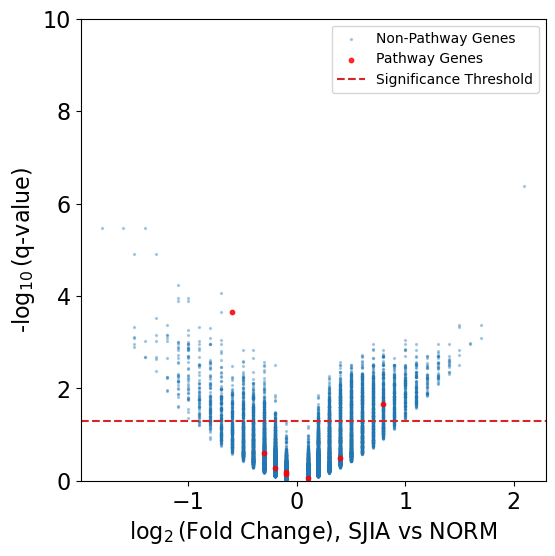

In [33]:
#volcano plot for PJIA vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["SJIA_vs_NORM_fc"],
            -np.log10(query_results["SJIA_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ra_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "SJIA_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "SJIA_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), SJIA vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot shows that seven genes are both in the RA pathway and the SJIA condition of the dataset. One of these genes is significantly downregulated, and one is significantly upregulated.

In [41]:
# select genes upregulated in SJIA vs normal
fc_sjia = query_results["SJIA_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_sjia = query_results["SJIA_vs_NORM_p"] < 0.05

# collect genes upregulated in SJIA vs normal
sjia_slice = query_results[fc_sjia & q_sjia]
sjia_slice.iloc[:, [0,1,8,9]]

,Gene ID,Gene Name,SJIA_vs_NORM_fc,SJIA_vs_NORM_p
21,ENSG00000002726,AOC1,1.1,0.026779
34,ENSG00000003402,CFLAR,0.8,0.009191
58,ENSG00000004897,CDC27,0.3,0.038024
59,ENSG00000004939,SLC4A1,1.1,0.018914
64,ENSG00000005020,SKAP2,0.6,0.024003
...,...,...,...,...
20393,ENSG00000285399,ENSG00000285399,0.9,0.007844
20399,ENSG00000285444,ENSG00000285444,1.1,0.021506
20408,ENSG00000285534,ENSG00000285534,0.9,0.048701
20464,ENSG00000285938,ENSG00000285938,1.1,0.007905


1837 of the 58735 genes in the dataset are significantly upregulated in SJIA. This represents 3.13% of the genes in the dataset.

In [35]:
# determine which genes in both sjia_slice & ra_pathway
sjia_cond = sjia_slice['Gene Name'].isin(ra_pathway)
sjia_filter = sjia_slice[sjia_cond]
sjia_filter.iloc[:, [0,1,8,9]]

,Gene ID,Gene Name,SJIA_vs_NORM_fc,SJIA_vs_NORM_p
13006,ENSG00000197208,SLC22A4,0.8,0.022303


One gene, SLC22A4, is in both the RA pathway and is significantly upregulated in SJIA.

In [36]:
# number of genes in pjia_cond2
k = np.sum(pjia_cond2)
# number of genes in pjia_slice2
N = len(pjia_slice2)
# number of genes in both query_results & ra_pathway
n = np.sum(query_results['Gene Name'].isin(ra_pathway))
# number of genes in query_results
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 766
n = 10
M = 20473
Enrichment ratio: 2.6727154046997392
p-value: 0.3171061751210223


The p-value of .32 (> .05) shows that the RA pathway is not significantly enriched in those with SJIA. This is unexpected, as SJIA is an RA and we would expect these genes to be upregulated. It's possible that the genes in the RA pathway are actually downregulated in SJIA instead of upregulated. I will test that next.

In [37]:
# select genes downregulated in SJIA vs normal
fc_sjia2 = query_results["SJIA_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_sjia2 = query_results["SJIA_vs_NORM_p"] < 0.05

# collect genes downregulated in SJIA vs normal
sjia_slice2 = query_results[fc_sjia2 & q_sjia2]
sjia_slice2.iloc[:, [0,1,6,7]]

,Gene ID,Gene Name,PJIA_vs_NORM_fc,PJIA_vs_NORM_p
5,ENSG00000000971,CFH,-0.3,0.326698
27,ENSG00000003056,M6PR,-0.2,0.039884
40,ENSG00000004139,SARM1,-0.2,0.126574
61,ENSG00000004975,DVL2,-0.3,0.064652
81,ENSG00000005379,TSPOAP1,-0.8,0.000676
...,...,...,...,...
19740,ENSG00000277089,CCL3-AS1,NaN,NaN
19928,ENSG00000279117,ENSG00000279117,-0.2,0.118841
20197,ENSG00000281103,TRG-AS1,-0.3,0.045119
20235,ENSG00000282173,TRBJ1-5,-0.3,0.257204


In [39]:
# determine which genes in both pjia_slice & jia_pathway
sjia_cond2 = sjia_slice2['Gene Name'].isin(ra_pathway)
sjia_filter2 = sjia_slice2[sjia_cond2]
sjia_filter2.iloc[:, [0,1,8,9]]

,Gene ID,Gene Name,SJIA_vs_NORM_fc,SJIA_vs_NORM_p
4414,ENSG00000122223,CD244,-0.6,0.000225


One gene, CD244, is in both the RA pathway and is significantly downregulated in SJIA. Notably, this is the only gene from the RA pathway that was significantly downregulated in OJIA and PJIA.

In [40]:
# number of genes in sjia_cond2
k = np.sum(sjia_cond2)
# number of genes in sjia_slice2
N = len(sjia_slice2)
# number of genes in both query_results & ra_pathway
n = np.sum(query_results['Gene Name'].isin(ra_pathway))
# number of genes in query_results
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 710
n = 10
M = 20473
Enrichment ratio: 2.883521126760564
p-value: 0.297446280976001


The p-value of .30 (> .05) shows that the RA pathway isn't significantly diminished in those with SJIA. This is unexpected, as SJIA is an RA so we would expect these genes to be either upregulated or downregulated and neither is true. These results correspond to the volcano plot, which shows several genes, but only two of which are significantly upregulated or downregulated. These results also correspond to the results for OJIA and PJIA, which didn't have significant enrichment or diminishment of the RA pathway.

# **Summary**

The IBD pathway was found to be significantly diminished in Crohn's disease, but neither significantly enriched nor significantly diminished in UC. The RA pathway was found to be neither significantly enriched nor significantly diminished in OJIA, PJIA, or SJIA. Aside from Crohn's disease, these results were unexpected, as  differential gene expression would be expected for the disease pathway of patients with that particular disease. Possible explanations for these results could be that neither pathway has many genes, so not every gene that would experience differential expression is necessarily accountee for. Additionally, some genes in the pathway are enriched and some are diminished, so different genes in the pathway may experience different changes in expression instead of all changing in the same direction.

# **References**

Mo A, Marigorta UM, Arafat D, et al. Disease-specific regulation of gene expression in a comparative analysis of juvenile idiopathic arthritis and inflammatory bowel disease. Genome Medicine. 2018 Jun;10(1):48. DOI: 10.1186/s13073-018-0558-x. PMID: 29950172; PMCID: PMC6020373.